**Section 1- Business Understanding**

I am using a publicly available dataset containing information on Airbnb properties within Edinburgh. I aim to answer the three following questions:

1. Are Guests More Likely to Leave Reviews if Dissatisfied?
2. Which Features Are Most Likely to Influence the Rating Provided?
3. How Can You Increase the Chance of Your Property Getting Rated Highly?

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import re

**Section 2- Data Understanding**

The data provided by Airbnb included a listing, calendar and review set. Initially both the listing and calendar set were going to be utilised, however without fairly extensive sentiment analysis, the review set offered no more information than what is included in the listing dataset. I therefore am just using the listing dataset. Initially focus was to be on patterns regarding the number of reviews per month. However, following assessment, it was instead decided to focus on rating. 

***Gather***

In [4]:
import pandas as pd 

listing_df=pd.read_csv('listings.csv.gz')
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12658 entries, 0 to 12657
Columns: 106 entries, id to reviews_per_month
dtypes: float64(23), int64(21), object(62)
memory usage: 10.2+ MB


***Assess***

[Text(0, 0.5, 'Number of Review per Month'),
 Text(0.5, 0, 'Rating'),
 Text(0.5, 1.0, 'Are Displeased Guests More Likely to Give Feedback?')]

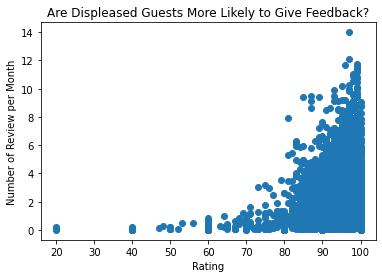

In [5]:
# Examining relationship between number of reviews and the rating of properties
q1_cols=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location','review_scores_value', 'reviews_per_month', 'number_of_reviews', 'number_of_reviews_ltm']

df_q1=listing_df[q1_cols]
df_q1=df_q1.dropna()

fig, ax = plt.subplots()
ax.scatter(df_q1['review_scores_rating'], df_q1['reviews_per_month'])
ax.set(ylabel='Number of Review per Month', xlabel='Rating', title= 'Are Displeased Guests More Likely to Give Feedback?')

*Initial assessment shows that the vast majority of reviews are highly rated, suggesting customers are  more likely to leave reviews when they are satisfied. Alternatively, the data may be biased on account of the industry*

**Section 3- Prepare Data**

In order to get the data ready for modelling adjustments were made: 
- Fields containing extensive text were dropped in the absence of sentiment analysis or similar
- IDs dropped as irrelevant to model 
- Further fields found to have minimal entries dropped eg neighbourhood_group_cleansed, square_feet
- Nulls dropped where difficult to impute and minimal entries missing
- Monetary values replaced with floats and years as host derived
- Mean scores used for review score imputation 
- Dummies used for categorical variables

***Clean***

In [6]:
# Extracting all relevant fields and dropping any with a very high proportion of null values 
obj_cols=['host_since','host_is_superhost', 'host_has_profile_pic', 'host_identity_verified','price', 'security_deposit', 'cleaning_fee', 'requires_license', 'instant_bookable', 'is_business_travel_ready', 'require_guest_profile_picture', 'require_guest_phone_verification', 'is_location_exact', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
num_cols_drop=['id', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'latitude', 'longitude', 'jurisdiction_names', 'scrape_id', 'host_id']

obj_cols_drop=list(listing_df.select_dtypes(include=['object']).drop(obj_cols, axis=1).columns)
drop_cols=obj_cols_drop+num_cols_drop
df_mod= listing_df.drop(drop_cols, axis=1)

df_mod=df_mod.drop(['neighbourhood_group_cleansed', 'square_feet'], axis=1)
df_mod=df_mod.dropna(subset=['reviews_per_month', 'accommodates', 'bathrooms', 'bedrooms', 'beds'])

In [7]:
# deriving the years that the host has been a host and removing dollar signs from cost values 
df_mod=df_mod.assign(years_as_host=lambda x: 2020- pd.DatetimeIndex(x['host_since']).year,
                  flt_price=lambda x: x['price'].str.replace(',', '').str.replace('$', '').astype(float),
                  flt_dep=lambda x: x['security_deposit'].str.replace(',', '').str.replace('$', '').astype(float).fillna(0),
                  flt_clean=lambda x: x['cleaning_fee'].str.replace(',', '').str.replace('$', '').astype(float).fillna(0),
                  # Initially area code included but dramatically reduced accuracy of model 
                  #area= lambda x: x["zipcode"].str.extract(r"([A-Z]*\d+)")  
                    )

df_mod=df_mod.drop(['host_since', 'price', 'security_deposit', 'cleaning_fee'], axis=1)

In [8]:
# Imputing mean across review scores
rev=['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

for r in rev:
    df_mod[r]=df_mod[r].fillna(df_mod[r].mean())

In [9]:
# check all objects now categorical features, 
col=df_mod.select_dtypes(include=object).columns

# converting to dummy values accordingly 
df_mod_fin= pd.concat([df_mod.drop(col, axis=1), pd.get_dummies(df_mod[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=False)], axis=1)
df_mod_fin=df_mod_fin.drop(['number_of_reviews', 'number_of_reviews_ltm'], axis=1)

**Section 4- Data Modelling**

Functions for linear modelling using both Ridge and Linear regression were produced. Allowed for comparison between predictive power and feature importance. Data then split to make the review_scores_rating the target. 

In [10]:
def LRmod(X, y, t_size):
    
    '''
    Function for fitting, predicting and scoring using a linear regression model 
    
    In:
    X- input vector
    y- target values
    t_size- size of test population 
    
    Out:
    test_score- r^2 score using test population 
    test_score- r^2 score using test population 
    co- estimated coefficients of model 
    '''
    
    # Splitting 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=42)

    # Fitting 
    mod = LinearRegression(normalize=True) 
    mod.fit(X_train, y_train)

    # Predicting 
    y_test_preds = mod.predict(X_test)
    y_train_preds = mod.predict(X_train)

    # Scoring 
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    # Estimating coefficients
    co= mod.coef_
    
    return test_score, train_score, co

In [11]:
def RDGmod(X, y, t_size, A):

    '''    
    Function for fitting, predicting and scoring using a ridge regression model 
    
    In:
    X- input vector
    y- target values
    t_size- size of test population 
    A- alpha, regularization strength 
    
    Out:
    test_score- r^2 score using test population 
    test_score- r^2 score using test population 
    co- estimated coefficients of model 
    '''
    
    # Splitting 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size, random_state=42)

    # Fitting 
    mod = Ridge(normalize=True, alpha=A) # Instantiate
    mod.fit(X_train, y_train) #Fit

    # Predicting 
    y_test_preds = mod.predict(X_test)
    y_train_preds = mod.predict(X_train)

    #Scoring
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    
    # Estimating coefficients
    co= mod.coef_
    
    return test_score, train_score, co

***Model***

In [12]:
# Splitting into input and target values 
y_var=['review_scores_rating']
y=df_mod_fin[y_var]
X=df_mod_fin.drop(y_var, axis=1)
X=X.drop(['host_total_listings_count'], axis=1)

# Running linear regression model 
test_score, train_score, co_LR =LRmod(X, y, 0.3)
print("rsquared on training data == {}, rsquared on test data == {}.".format(train_score, test_score))

# Running ridge regression model 
A=0.1
test_score, train_score, co_RDG =RDGmod(X, y, 0.3, A)
print("With alpha= {}: rsquared on training data == {}, rsquared on test data == {}.".format(A, train_score, test_score))

rsquared on training data == 0.7299181185239985, rsquared on test data == 0.713696458081685.
With alpha= 0.1: rsquared on training data == 0.7283329794858002, rsquared on test data == 0.7159196716420437.


**Section 5- Data Understanding**

Both initial data and model outputs used to answer business questions. 

***Analyse***

In [13]:
# Produces table with raw and absolute coefficients for both models used
co_df=pd.DataFrame()


co_df=co_df.assign(Coefficient= X.columns,
            LR_val= co_LR[0],
            LR_val_abs= abs(co_LR[0]),
            RDG_val= co_RDG[0], 
            RDG_val_abs= abs(co_RDG[0]))

co_df.sort_values(by=['LR_val_abs'], ascending=False).head(20)

,Coefficient,LR_val,LR_val_abs,RDG_val,RDG_val_abs
60,property_type_Resort,-11.575535,11.575535,-8.630465,8.630465
62,property_type_Tent,-10.420730,10.420730,-8.383691,8.383691
50,property_type_Dome house,-10.111740,10.111740,-8.198657,8.198657
54,property_type_Hostel,-4.945509,4.945509,-3.994834,3.994834
57,property_type_Hut,-4.808833,4.808833,-3.846016,3.846016
46,property_type_Castle,-4.691405,4.691405,-2.517905,2.517905
78,cancellation_policy_super_strict_30,4.470822,4.470822,4.321120,4.321120
51,property_type_Farm stay,3.870625,3.870625,4.613696,4.613696
41,property_type_Boutique hotel,-3.012741,3.012741,-1.142776,1.142776
18,review_scores_accuracy,2.747969,2.747969,2.555316,2.555316


***Visualise***

Q1: Are Guests More Likely to Leave Reviews if Dissatisfied?

[Text(0, 0.5, 'Number of Review per Month'),
 Text(0.5, 0, 'Rating'),
 Text(0.5, 1.0, 'Are Displeased Guests More Likely to Give Feedback?')]

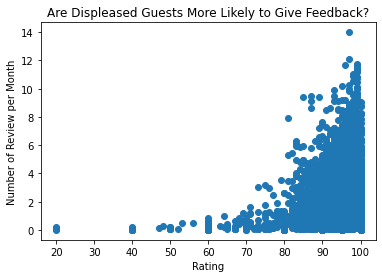

In [14]:
# Analysing relationship between rating and number of reviews per month using cleaned data
fig, ax = plt.subplots()
ax.scatter(df_mod_fin['review_scores_rating'], df_mod_fin['reviews_per_month'])
ax.set(ylabel='Number of Review per Month', xlabel='Rating', title= 'Are Displeased Guests More Likely to Give Feedback?')

*Further assessment with clean data reinforces that the vast majority of reviews are highly rated, suggesting customers are  more likely to leave reviews when they are satisfied. Alternatively, the data may be biased on account of the industry*

[Text(0, 0.5, 'reviews_per_month'), Text(0.5, 0, 'availability_365')]

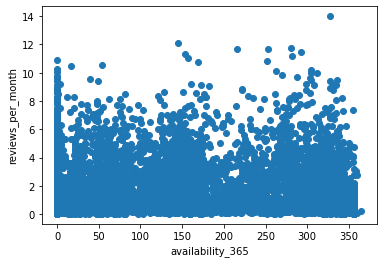

In [15]:
# Further analysis for any obvious relationship between  no. reviews per month and availability, assuming availability is an indication of the number of guests that have visited
fig, ax = plt.subplots()
ax.scatter(df_mod_fin['availability_365'], df_mod_fin['reviews_per_month'])
ax.set(ylabel='reviews_per_month', xlabel='availability_365')

*Plot shows no obvious correlation between the number of reviews per month and the availability of the property, this suggests the availability may not be representative of the number volume of guests the property has. Alternatively, the volume of guests is not representative of the number of reviews*

Q2: Which Features Are Most Likely to Influence the Rating Provided?

[Text(0.5, 1.0, 'Relative Importance of Features')]

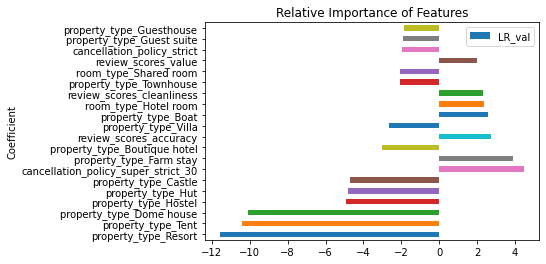

In [16]:
# Bar chart demonstrating features important in logistic regression model 
co_bar_df=co_df.sort_values(by=['LR_val_abs'], ascending=False).head(20)

ax = co_bar_df.plot.barh(x='Coefficient', y='LR_val')
ax.set(title= 'Relative Importance of Features')

*Chart clearly shows property type is the most important feature in the model. Subsets of review scores makes an unsuprising appearance. Room type is expected based on the prevalence of property type as a feature while cancellation policy is perhaps harder to explain.* 

Q3: How Can You Increase the Chance of Your Property Getting Rated Highly?

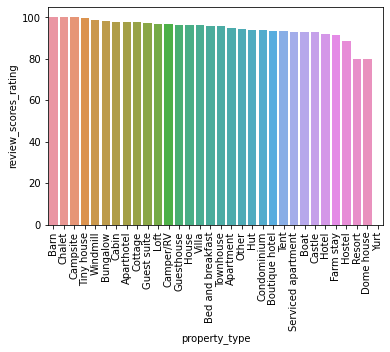

In [17]:
# Generating a Bar Chart showing the average Rating receieved by Property type
prop_df=listing_df.groupby('property_type')[['review_scores_rating']].mean().reset_index().sort_values(by='review_scores_rating', ascending=False)
prop_plt=sns.barplot(x='property_type', y="review_scores_rating", data=prop_df)

for item in prop_plt.get_xticklabels():
    item.set_rotation(90)

*Chart shows a steady reduction in rating acrpss the property types. Barns, chalets and campsites get the highest ratings, while dome houses and resorts suffer. It is worth noting that the property types at either ends are likely less common than those in the centre*

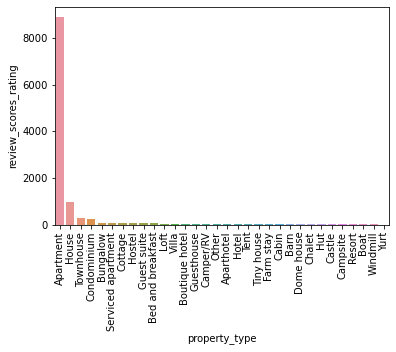

In [20]:
# Generating a Bar Chart showing the number of Rating receieved by Property type
prop_df=listing_df.groupby('property_type')[['review_scores_rating']].count().reset_index().sort_values(by='review_scores_rating', ascending=False)
prop_plt=sns.barplot(x='property_type', y="review_scores_rating", data=prop_df)

for item in prop_plt.get_xticklabels():
    item.set_rotation(90)

*As expected, the more common property types tend to be in the centre of the previous graph. In future, analysing by property type may provide deeper insight.*

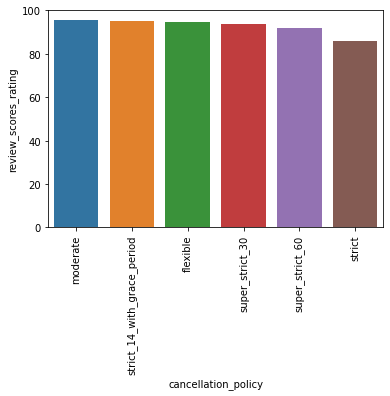

In [18]:
# Generating a Bar Chart showing the average Rating receieved by Cancellation Policy
prop_df=listing_df.groupby('cancellation_policy')[['review_scores_rating']].mean().reset_index().sort_values(by='review_scores_rating', ascending=False)
prop_plt=sns.barplot(x='cancellation_policy', y="review_scores_rating", data=prop_df)

for item in prop_plt.get_xticklabels():
    item.set_rotation(90)

*Chart appears to show more relaxed policies to the left and stricter to the right but in no particular order*